<a href="https://colab.research.google.com/github/mgnarag/binarization-lowres/blob/main/Metric.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [34]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ls drive/My\ Drive
file_path = "/content/drive/My Drive/Architectural_designs/From Arki/"

In [36]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf


from PIL import Image, ImageOps
Image.MAX_IMAGE_PIXELS = None
import os
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import pandas as pd

from tensorflow import keras

import time
import os
import cv2

In [37]:


def crop(im):
    width, height = im.size
    data = []
    for j in range(0,int(height/n_size)):
        for i in range(0,int(width/n_size)):
            im1 = im.crop((0 + (n_size*i), 0 + (n_size*j), n_size + (n_size*i), n_size + (n_size*j)))
            im1 = np.array(im1)
            im1 = im1.astype(np.float32)
            im1 = im1/255
            data.append(im1)
    return data

def normalize(arr):
    """
    Linear normalization
    http://en.wikipedia.org/wiki/Normalization_%28image_processing%29
    """
    arr = arr.astype('float')
    # Do not touch the alpha channel
    for i in range(3):
        minval = arr[...,i].min()
        maxval = arr[...,i].max()
        if minval != maxval:
            arr[...,i] -= minval
            arr[...,i] *= (255.0/(maxval-minval))
    return arr


In [74]:
gt = Image.open(file_path+ '4 Testing/ground_truth.png').convert('L')
img_gt = cv2.imread(file_path+ '4 Testing/ground_truth.png')
gt = np.asarray(gt) > 128
gt = ~gt

filename = "nbs.png"
directory = file_path + '4 Testing/' + filename
#directory = 'test_output_v'+str(model)+'.png'
dirty = ImageOps.grayscale(Image.open(directory))
dirty = np.array(dirty)
dirty = Image.fromarray(normalize(dirty).astype('uint8'))

w_dirty, h_dirty = dirty.size


METRIC = []

for model in range(1,7):
    print('Model = ', model)
    from tensorflow import keras
    autoencoder = keras.models.load_model(file_path + '1 Models/autoencoder_'+str(model))
    if model == 1:
        n_size = 32
    if model == 2:
        n_size = 32
    if model == 3:
        n_size = 64
    if model == 4:
        n_size = 64
    if model == 5:
        n_size = 128
    if model == 6:
        n_size = 128
    if model == 7:
        n_size = 256
    if model == 8:
        n_size = 256

    xx = int(w_dirty/n_size)
    final=[]

    for portion in range(0,xx):
        #print("current portion to clean:", str(portion))

        im1 = dirty.crop((n_size*portion, 0, (n_size*portion) + n_size, h_dirty))
        w1, h1 = im1.size
        w = int(w1/n_size)
        h = int(h1/n_size)

        neverbeforeseen = np.array(crop(im1))
        encoded_imgs = autoencoder.encoder(neverbeforeseen).numpy()
        decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

        col = np.vstack((decoded_imgs[0],decoded_imgs[1]))
        for i in range(2,h):
            col = np.vstack((col,decoded_imgs[i]))

        y = np.where(col > 0.5,1,0) #round the values
        y = (y * 255).astype('uint8')
        if portion == 0:
            final = y
        if portion > 0:
            final = np.hstack((final,y))

    final = np.squeeze(final)
    reconstructed = Image.fromarray(final)
    reconstructed.save(file_path + "5 Tested/output v" + str(model) + '.png')

    output = Image.open(file_path + "5 Tested/output v" + str(model) + '.png').convert('L')  # convert to grayscale
    img_out = cv2.imread(file_path + "5 Tested/output v" + str(model) + '.png')

    #output = output.crop((0, 0, 3200, 5632))
    #img_out = img_out[0:5632 , 0:3200]

    #psnr = cv2.PSNR(img_out/255, img_gt/255)
    # Convert to binary images
    output = np.asarray(output) > 128
    output = ~output

    tp = np.sum(output & gt)
    fp = np.sum(output & ~gt)
    fn = np.sum(~output & gt)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1score = (2*precision*recall)/(precision + recall)

    I_1 = output & gt
    O_1 = output | gt
    I = np.sum(output & gt)
    O = np.sum(output | gt)
    i_o_u = I/O

    psnr = cv2.PSNR(img_out, img_gt)

    METRIC.append([model, precision,recall,f1score,i_o_u,psnr])

METRIC = pd.DataFrame(METRIC)

headers = ['Model','Precision', 'Recall', 'F1 Score', 'IOU','PSNR' ]
METRIC.columns = headers

METRIC.to_csv(file_path + 'Metric.csv')

Model =  1
Model =  2
Model =  3
Model =  4
Model =  5
Model =  6


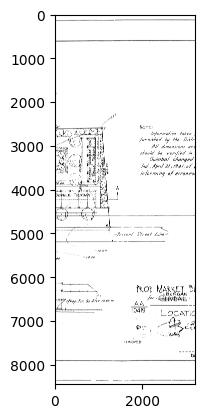

In [70]:
TP = output & gt
TP = Image.fromarray(~TP)
plt.imshow(TP,cmap = 'gray')
TP.save(file_path + "5 Tested/TP.png")

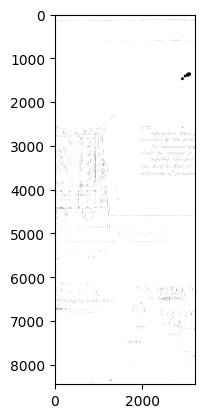

In [72]:
FP = output & ~gt
FP = Image.fromarray(~FP)
plt.imshow(FP,cmap = 'gray')
FP.save(file_path + "5 Tested/FP.png")

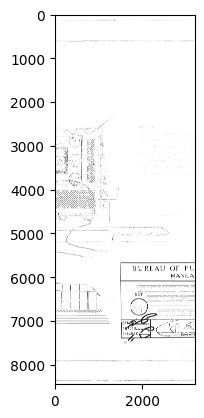

In [73]:
FN = ~output & gt
FN = Image.fromarray(~FN)
plt.imshow(FN,cmap = 'gray')
FN.save(file_path + "5 Tested/FN.png")